Implementation and comparision of LSTM(Long Short Term Memory) and ARIMA(Autoregressive integrated moving average) Neural Networks for the application of Stock Price Prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from example_functions import fetch_store, preprocessing_data, generate_sequence

We shall follow the following steps to achieve the goal:
1. Fetch and store the data(Stock Prices for the past few time intervals).
2. Split the data for Training and Testing.
3. Processing of data to meet the input criterion of the Neural Network Algorithms.
4. Pass the data through LSTM and ARIMA and train the networks.
5. Start Predicting the upcoming Stock Prices for the next few time intervals using the 2 models.
6. Compare the results of the 2 models and conclude.


The following code has all the required functions used by the main function

In [2]:
## Configuration Parameters

# Used to divide the data into training set and test set i.e.,
# Percentage of Training data in the whole set of data
percentage_train_data = 0.75

# Dependence Interval specifies the number of previous intervals used
# to predict the next interval's output
dependence_interval = 100

# Name of the file used to extract data
file_name = "TSLA.csv"


## Step - 1
# Fetches and Stores data
%run -i example_functions.py
data = fetch_store ()

print("1 : ", len(data))

## Step - 2
# Preprocesses the data for LSTM and Splits the data among training and testing 
%run -i example_functions.py
scaler, processed_data, processed_train_data, processed_test_data = preprocessing_data (data, percentage_train_data)


## Step - 3
# Creating Training and Test Sequence and the corresponding otput sequence from the data
%run -i example_functions.py
train_sequence, expected_train_output_seq = generate_sequence(processed_train_data, dependence_interval)
test_sequence, expected_test_output_seq = generate_sequence(processed_test_data, dependence_interval)

print("2 : ", len(data))
## Step - 4
# Call LSTM
model=Sequential()
# Check how this LSTM model works 
model.add(LSTM(50,return_sequences=True,input_shape=(train_sequence.shape[1],train_sequence.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
# Check
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(train_sequence,expected_train_output_seq,validation_data=(test_sequence,expected_test_output_seq),epochs=5,batch_size=64,verbose=1)

print("3 : ", len(data))

### Lets Do the prediction and check performance metrics
train_predict = model.predict(train_sequence)
test_predict = model.predict(test_sequence)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

##Removing log transform
train_predict = np.exp(train_predict)
test_predict = np.exp(test_predict)

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print("Empirical Error is ", math.sqrt(mean_squared_error(expected_train_output_seq, train_predict)))

### Test Data RMSE
print("True Error is ", math.sqrt(mean_squared_error(expected_test_output_seq,test_predict)))
print("4 : ", len(data))


1 :  2875
(2055, 100)
(2055, 100, 1)
(618, 100)
(618, 100, 1)
2 :  2875
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
33/33 [==============================] - 12s 184ms/step - loss: 0.0148 - val_loss: 0.0237
Epoch 2/5
33

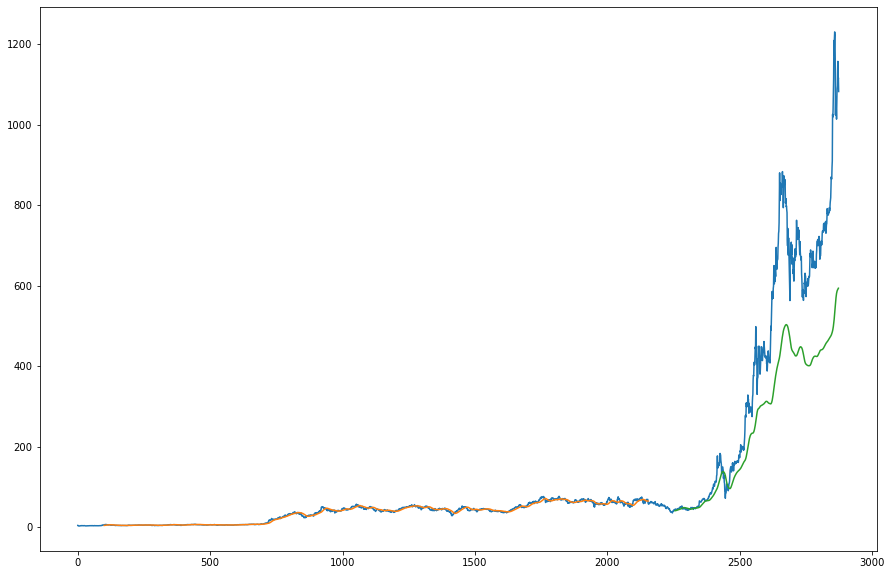

5 :  2875


In [3]:
### Plotting 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(processed_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[dependence_interval:len(train_predict)+dependence_interval, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(processed_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(dependence_interval*2)+1:len(processed_data)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=[15,10])
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
print("5 : ", len(data))

In [4]:
temp_input=list(processed_data[-1*dependence_interval-1:])
# print(len(temp_input))
lst_output=[]
n_steps=100
i=0
while(i<300):
    
    if(len(temp_input)>100):
#         print(i)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, dependence_interval, 1))
        yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0])
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, dependence_interval,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


Initial data type : <class 'pandas.core.series.Series'> with data :  2873    1116.000000
2874    1081.920044
Name: Close, dtype: float64
2nd array to be appended :  <class 'list'> with lst_out :  [array([596.04916262]), array([594.97479423])]
[]


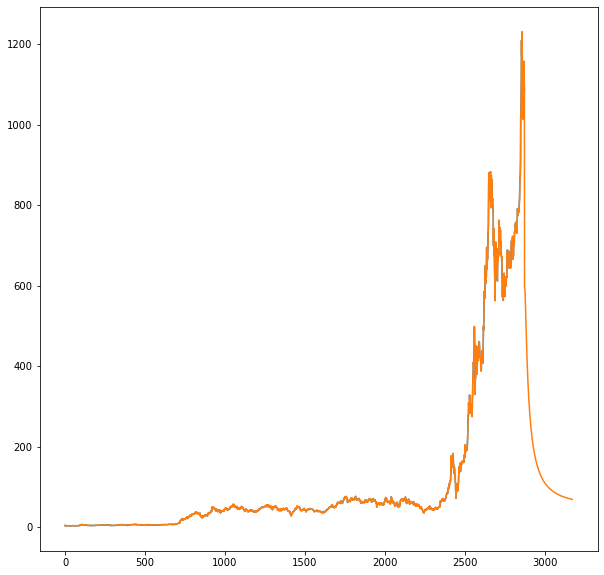

In [5]:
lst_out = list(np.exp(scaler.inverse_transform(lst_output)))

final_data = []
final_data.extend(data)
print("Initial data type :", type(data), "with data : ", data[-2:])
print("2nd array to be appended : ", type(lst_out), "with lst_out : ", lst_out[:2])

for iter in range(len(lst_out)):
    final_data.extend(lst_out[iter].tolist())
    
print(final_data[9998:10002])
plt.figure(figsize=[10,10])
plt.plot(data)
plt.plot(final_data)
plt.show()